
TABLE VI – Workload Features (per benchmark):
                 H_rg  H_rl  H_wg  H_wl  r_unique (10^6)  w_unique (10^6)  90%ft_r (10^3)  90%ft_w (10^3)  r_total (10^9)  w_total (10^9)
benchmark                                                                                                                                
500_perlbench_r  8.91   NaN   NaN   NaN             0.12              NaN             NaN             NaN             0.0             NaN
502_gcc_r        8.48  3.55   NaN   NaN             0.10              NaN             NaN             NaN             0.0             NaN
505_mcf_r        8.69  3.76   NaN   NaN             0.11              NaN             NaN             NaN             0.0             NaN
520_omnetpp_r    8.49  3.57   NaN   NaN             0.10              NaN             NaN             NaN             0.0             NaN
523_xalancbmk_r  9.03   NaN   NaN   NaN             0.12              NaN             NaN             NaN             0.0    

/tmp/ipykernel_1080286/1185871960.py:198: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


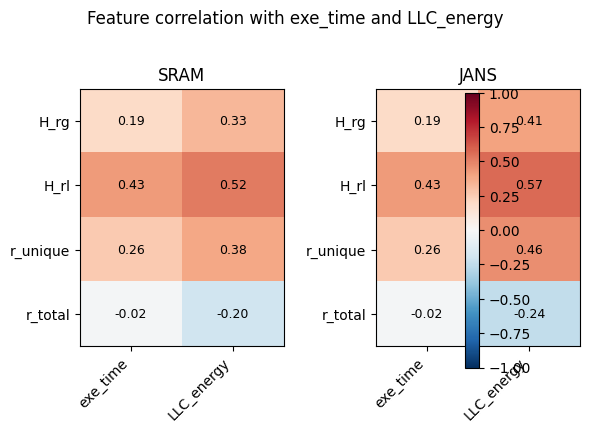

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Union, List # <-- Add this import

# ---------- 1) Pick "final if present else last" per benchmark ----------
def _pick_final_or_last_per_bench(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df.copy()

    df = df.copy()
    df["scope"] = df["scope"].astype(str)
    df["is_final"] = df["scope"].str.lower().eq("final")
    df["is_interval"] = df["scope"].str.lower().eq("interval")
    # keep stable interval order in case you ever need it
    df["interval_idx"] = df.groupby("benchmark")["is_interval"].cumsum().where(df["is_interval"], np.nan)
    df = df.sort_values(["benchmark", "interval_idx"], kind="mergesort")

    def pick(g):
        return g[g["is_final"]].tail(1) if g["is_final"].any() else g.tail(1)

    return (df.groupby("benchmark", group_keys=False)
              .apply(pick)
              .reset_index(drop=True))

# ---------- 2) Build Table-VI-like summary ----------
# CORRECTED THIS FUNCTION DEFINITION
def make_table_vi(dr_df: pd.DataFrame,
                  round_digits: int = 2,
                  save_csv: Union[str, None] = None,
                  save_tex: Union[str, None] = None) -> pd.DataFrame:
    """
    Returns a DataFrame with columns matching the example table:
      H_rg, H_rl, H_wg, H_wl, r_unique (10^6), w_unique (10^6),
      90%ft_r (10^3), 90%ft_w (10^3), r_total (10^9), w_total (10^9)
    """
    if dr_df.empty:
        return pd.DataFrame()

    dr_final2 = _pick_final_or_last_per_bench(dr_df)

    # Columns expected from your logs
    raw_cols = {
        "read_entropy": "H_rg",
        "read_local_entropy": "H_rl",
        "write_entropy": "H_wg",
        "write_local_entropy": "H_wl",
        "read_unique": "r_unique (10^6)",
        "write_unique": "w_unique (10^6)",
        "read_footprint90": "90%ft_r (10^3)",
        "write_footprint90": "90%ft_w (10^3)",
        "read_total": "r_total (10^9)",
        "write_total": "w_total (10^9)",
    }

    present = [c for c in raw_cols if c in dr_final2.columns]
    if not present:
        return pd.DataFrame()

    # Select & scale units for presentation
    tbl = dr_final2[["benchmark"] + present].copy()

    # Scale counts to match the labels in the figure
    scale_map = {
        "read_unique": 1e-6,
        "write_unique": 1e-6,
        "read_footprint90": 1e-3,   # adjust if your units differ
        "write_footprint90": 1e-3,  # adjust if your units differ
        "read_total": 1e-9,
        "write_total": 1e-9,
    }
    for c, fac in scale_map.items():
        if c in tbl.columns:
            tbl[c] = pd.to_numeric(tbl[c], errors="coerce") * fac

    # Rename to paper-style headers and round
    tbl = tbl.rename(columns=raw_cols).set_index("benchmark")
    tbl = tbl[list(raw_cols.values())].copy()  # enforce the column order we promised
    tbl = tbl.round(round_digits)

    # Optional saves
    if save_csv:
        tbl.to_csv(save_csv)
    if save_tex:
        with open(save_tex, "w") as fh:
            fh.write(tbl.to_latex(escape=False))  # LaTeX table for papers

    # Print to console like your current script
    print("\nTABLE VI – Workload Features (per benchmark):")
    print(tbl.to_string())

    return tbl

# ---------- 3) Correlation heatmaps (features × {exe_time, LLC_energy}) ----------
# CORRECTED THIS FUNCTION DEFINITION
def plot_feature_corr_heatmaps(dr_df: pd.DataFrame,
                               sniper_df: pd.DataFrame,
                               configs: Union[List[str], None] = None,
                               method: str = "spearman",
                               figsize=(8, 4)):
    """
    Draws one heatmap per config. Rows = features from the example table.
    Columns = ['exe_time', 'LLC_energy'] mapped from ['time_s','energy_total_J'].
    """
    if dr_df.empty or sniper_df.empty:
        print("No data for correlation heatmaps.")
        return

    dr_final2 = _pick_final_or_last_per_bench(dr_df)

    feature_cols = [
        ("read_entropy", "H_rg"),
        ("read_local_entropy", "H_rl"),
        ("write_entropy", "H_wg"),
        ("write_local_entropy", "H_wl"),
        ("read_unique", "r_unique"),
        ("write_unique", "w_unique"),
        ("read_footprint90", "90%ft_r"),
        ("write_footprint90", "90%ft_w"),
        ("read_total", "r_total"),
        ("write_total", "w_total"),
    ]
    # keep only features present
    feature_cols = [(c, lab) for c, lab in feature_cols if c in dr_final2.columns]

    metric_cols = [("time_s", "exe_time"), ("energy_total_J", "LLC_energy")]
    metric_cols = [(m, lab) for m, lab in metric_cols if m in sniper_df.columns]

    if not feature_cols or not metric_cols:
        print("Missing features or metrics for correlation.")
        return

    # Which configs to plot
    cfgs = (sorted(sniper_df["config"].dropna().astype(str).unique().tolist())
            if not configs else [c for c in configs if c in sniper_df["config"].astype(str).unique()])

    if not cfgs:
        print("No matching configs found in sniper_df['config'].")
        return

    n = len(cfgs)
    fig, axes = plt.subplots(1, n, figsize=(figsize[0]*n, figsize[1]), squeeze=False)
    cbar_im = None

    for j, cfg in enumerate(cfgs):
        ax = axes[0, j]

        sn_cfg = sniper_df[sniper_df["config"].astype(str) == cfg].copy()
        sn_cfg["benchmark"] = sn_cfg["benchmark"].astype(str)

        # Select columns & merge on benchmark
        feat_cols_only = [c for c, _ in feature_cols]
        perf_cols_only = [m for m, _ in metric_cols]
        sel = sn_cfg[["benchmark"] + perf_cols_only].copy()
        merged = pd.merge(dr_final2[["benchmark"] + feat_cols_only], sel, on="benchmark", how="inner")

        # Drop rows with all-NaN features or metrics
        merged = merged.dropna(subset=feat_cols_only + perf_cols_only, how="all")
        if merged.empty:
            ax.set_axis_off()
            ax.set_title(f"{cfg} (no data)")
            continue

        # Remove constant features (correlation undefined)
        variable_feats = [c for c in feat_cols_only if merged[c].nunique(dropna=True) > 1]
        if not variable_feats:
            ax.set_axis_off()
            ax.set_title(f"{cfg} (no variable features)")
            continue

        corr = merged[variable_feats + perf_cols_only].corr(method=method)
        corr = corr.loc[variable_feats, perf_cols_only]

        # Build display arrays & labels
        data = corr.to_numpy()
        row_labels = [dict(feature_cols)[c] for c in variable_feats]  # pretty names
        col_labels = [lab for _, lab in metric_cols]

        im = ax.imshow(data, cmap="RdBu_r", vmin=-1, vmax=1, aspect="auto")
        if cbar_im is None:
            cbar_im = im  # for a single shared colorbar later

        # Ticks & labels
        ax.set_xticks(range(len(col_labels)))
        ax.set_xticklabels(col_labels, rotation=45, ha="right")
        ax.set_yticks(range(len(row_labels)))
        ax.set_yticklabels(row_labels)
        ax.set_title(cfg)

        # Annotate correlation values
        for r in range(data.shape[0]):
            for c in range(data.shape[1]):
                ax.text(c, r, f"{data[r, c]:.2f}", va="center", ha="center", fontsize=9)

    # One shared colorbar
    fig.colorbar(cbar_im, ax=axes.ravel().tolist(), shrink=0.85, pad=0.02)
    fig.suptitle("Feature correlation with exe_time and LLC_energy", y=1.02, fontsize=12)
    fig.tight_layout()
    plt.show()

# You will need to define dr_df and sniper_df before running this
# For example:
# dr_df = pd.read_csv('your_dr_data.csv')
# sniper_df = pd.read_csv('your_sniper_data.csv')

# ---------- 4) Run both pieces ----------
table_vi = make_table_vi(dr_df, round_digits=2, save_csv=None, save_tex=None)
plot_feature_corr_heatmaps(dr_df, sniper_df, configs=["SRAM","JANS"], method="spearman", figsize=(3.0, 4.2))

DR rows: 2772
DR final-like rows: 12
      benchmark    scope  footprint_bytes  H_line  H_page  H_stride  reuse_rate   avg_stride  avg_line_stride  p_stride_le_64  p50_strideB  p90_strideB  p99_strideB  p50_strideL  p90_strideL  p99_strideL
500_perlbench_r interval           902208     NaN     NaN  3.151825    0.960925 2.835045e+06     23504.501403        0.413268         1024      8388608      8388608           16        65536        65536
      502_gcc_r interval           642624     NaN     NaN  3.132098    0.965921 2.683794e+06     21892.772217        0.424683         1024      8388608      8388608           16        65536        65536
      505_mcf_r interval           785024     NaN     NaN  3.146010    0.963532 2.745187e+06     22557.724265        0.420492         1024      8388608      8388608           16        65536        65536
  520_omnetpp_r interval           646656     NaN     NaN  3.133041    0.965847 2.685014e+06     21908.439073        0.424672         1024      838

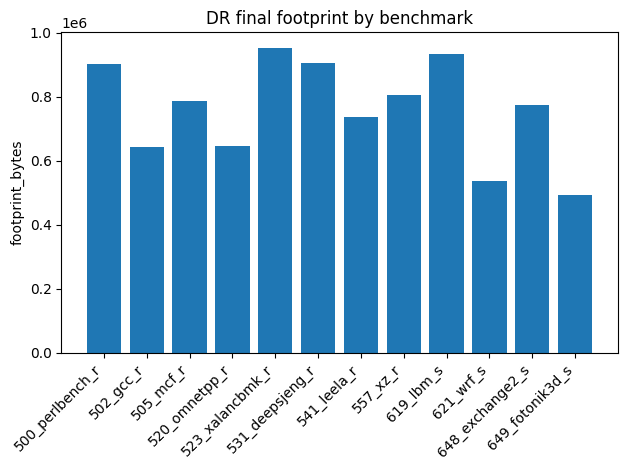

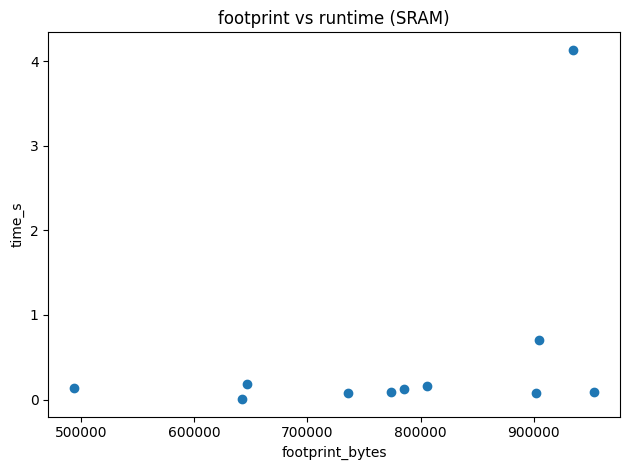

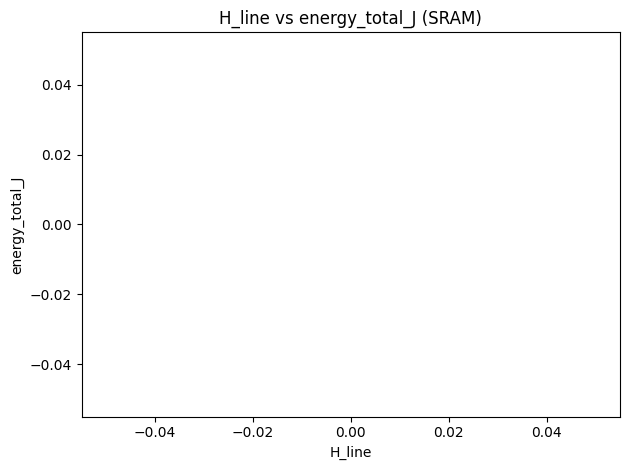

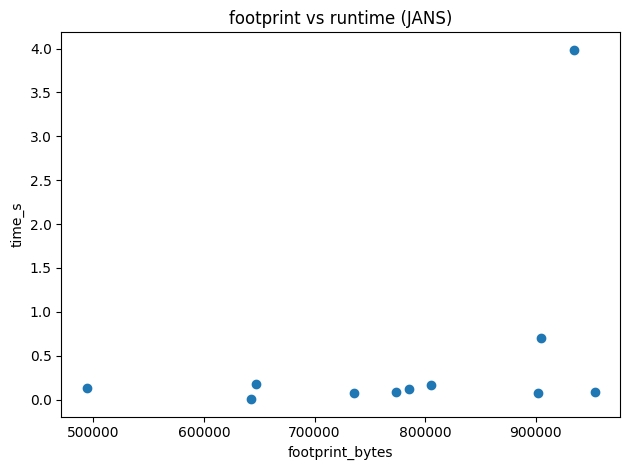

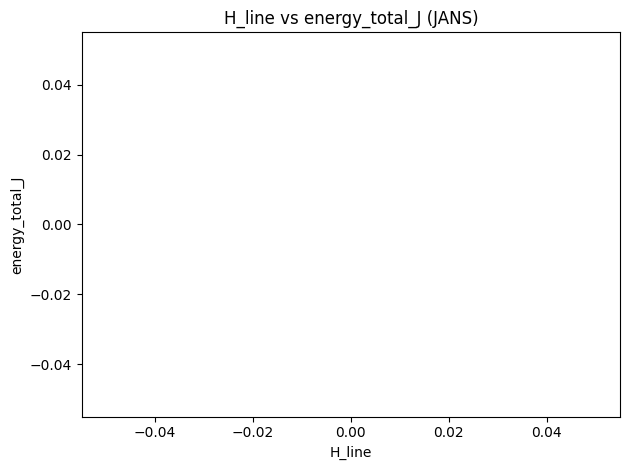

In [18]:
import os, re, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

log_dir = "/home/skataoka26/COSC_498/miniMXE/results_trace/logs"
sniper_root = "/home/skataoka26/COSC_498/miniMXE/results/sniper_roi500_20250926T231530Z"

rows = []
for f in sorted(glob.glob(os.path.join(log_dir, "*_instr.rwstats.log"))):
    m = re.search(r"\d{8}T\d{6}Z_(.+?)_instr\.rwstats\.log$", os.path.basename(f))
    if not m:
        continue
    bench = m.group(1)
    with open(f, "r", encoding="utf-8", errors="ignore") as fh:
        for line in fh:
            line = line.strip()
            if not line.startswith("scope="):
                continue
            parts = line.split(",")
            rec = {"benchmark": bench}
            for p in parts:
                if "=" in p:
                    k, v = p.split("=", 1)
                    k = k.strip(); v = v.strip()
                    try:
                        if v.lower() == "nan":
                            rec[k] = np.nan
                        else:
                            rec[k] = float(v) if (("." in v) or ("e" in v.lower())) else int(v)
                    except:
                        rec[k] = v
            rows.append(rec)

dr_df = pd.DataFrame(rows)
if not dr_df.empty:
    dr_df["scope"] = dr_df["scope"].astype(str)
    dr_df["is_final"] = dr_df["scope"].str.lower().eq("final")
    dr_df["is_interval"] = dr_df["scope"].str.lower().eq("interval")
    dr_df["interval_idx"] = dr_df.groupby("benchmark")["is_interval"].cumsum().where(dr_df["is_interval"], np.nan)
    dr_df = dr_df.sort_values(["benchmark","interval_idx"], kind="mergesort")

print("DR rows:", len(dr_df))

dr_final = dr_df[dr_df["is_final"]].copy()
if dr_final.empty and not dr_df.empty:
    dr_final = dr_df.groupby("benchmark", as_index=False).tail(1).copy()

dr_feat_cols = ["footprint_bytes","H_line","H_page","H_stride","reuse_rate","avg_stride","avg_line_stride","p_stride_le_64","p50_strideB","p90_strideB","p99_strideB","p50_strideL","p90_strideL","p99_strideL"]
dr_final = dr_final[["benchmark","scope"] + [c for c in dr_feat_cols if c in dr_final.columns]].copy()

out_dirs = sorted(glob.glob(os.path.join(sniper_root, "output_*")))
sn_list = []
for od in out_dirs:
    bench = os.path.basename(od).replace("output_","")
    eb = os.path.join(od, "energy_bounds.csv")
    sm = os.path.join(od, "summary.csv")
    if not (os.path.isfile(eb) and os.path.isfile(sm)):
        continue
    try:
        e = pd.read_csv(eb)
        s = pd.read_csv(sm)
    except:
        continue
    e["benchmark"] = bench
    s["benchmark"] = bench
    if "config" in e.columns: e["config"] = e["config"].astype(str).str.upper()
    if "config" in s.columns: s["config"] = s["config"].astype(str).str.upper()
    if "time_ns" in s.columns:
        s["time_s_from_summary"] = s["time_ns"].astype(float) / 1e9
    if "dyn_exact_nJ" in e.columns:
        e["dyn_exact_J"] = e["dyn_exact_nJ"].astype(float) / 1e9
    else:
        if "dyn_exact_J" not in e.columns:
            e["dyn_exact_J"] = np.nan
    if "energy_exact_J" in e.columns:
        e["energy_total_J"] = e["energy_exact_J"].astype(float)
    else:
        e["energy_total_J"] = e.get("dyn_exact_J", pd.Series(np.nan, index=e.index)).astype(float) + e.get("leak_J", pd.Series(np.nan, index=e.index)).astype(float)
    cols_e = ["benchmark","n_m","config","time_s","leak_J","dyn_exact_J","energy_total_J"]
    cols_s = ["benchmark","config","time_ns","ipc","instructions","cycles","time_s_from_summary"]
    e2 = e[[c for c in cols_e if c in e.columns]].copy()
    s2 = s[[c for c in cols_s if c in s.columns]].copy()
    m = pd.merge(e2, s2, on=["benchmark","config"], how="outer")
    m["benchmark"] = bench
    sn_list.append(m)

sniper_df = pd.concat(sn_list, ignore_index=True) if sn_list else pd.DataFrame()
if sniper_df.empty:
    print("No Sniper data found under:", sniper_root)

if not sniper_df.empty:
    sniper_df["config"] = sniper_df["config"].astype(str).str.upper()
    roi_mode = sniper_df["n_m"].dropna().mode()
    roi_pick = int(roi_mode.iloc[0]) if not roi_mode.empty else None
    if roi_pick is not None:
        sniper_df = sniper_df[(sniper_df["n_m"]==roi_pick) | (sniper_df["n_m"].isna())].copy()
    if "time_s_from_summary" in sniper_df.columns:
        sniper_df["time_s"] = sniper_df["time_s_from_summary"].where(sniper_df["time_s_from_summary"].notna(), sniper_df.get("time_s"))
    sniper_df["time_s"] = pd.to_numeric(sniper_df.get("time_s"), errors="coerce")
    sniper_df["instructions"] = pd.to_numeric(sniper_df.get("instructions"), errors="coerce")
    sniper_df["cycles"] = pd.to_numeric(sniper_df.get("cycles"), errors="coerce")
    sniper_df["ipc"] = pd.to_numeric(sniper_df.get("ipc"), errors="coerce")
    sniper_df["energy_total_J"] = pd.to_numeric(sniper_df.get("energy_total_J"), errors="coerce")
    sniper_df["dyn_exact_J"] = pd.to_numeric(sniper_df.get("dyn_exact_J"), errors="coerce")
    sniper_df["leak_J"] = pd.to_numeric(sniper_df.get("leak_J"), errors="coerce")
    sniper_df["time_per_instr"] = sniper_df["time_s"] / sniper_df["instructions"]
    sniper_df["energy_per_instr"] = sniper_df["energy_total_J"] / sniper_df["instructions"]

print("DR final-like rows:", len(dr_final))
print(dr_final.sort_values("benchmark").to_string(index=False))

if not sniper_df.empty:
    print("\nSniper rows (filtered):", len(sniper_df))
    print(sniper_df.sort_values(["benchmark","config"]).head(12).to_string(index=False))

def corr_tables_for_config(cfg):
    if sniper_df.empty or dr_final.empty:
        return None, None, None
    sn_cfg = sniper_df[sniper_df["config"]==cfg].copy()
    if sn_cfg.empty:
        return None, None, None
    perf_cols = ["time_s","time_per_instr","energy_total_J","energy_per_instr","dyn_exact_J","leak_J","ipc","instructions","cycles"]
    sn_sel = sn_cfg[["benchmark"] + [c for c in perf_cols if c in sn_cfg.columns]].copy()
    merged = pd.merge(dr_final, sn_sel, on="benchmark", how="inner")
    if merged.empty:
        return None, None, None
    if "time_s" in merged.columns:
        merged = merged[ (merged["time_s"].isna()) | (merged["time_s"] >= 0.01) ].copy()
    feat_cols = [c for c in dr_feat_cols if c in merged.columns]
    const_feats = [c for c in feat_cols if merged[c].nunique(dropna=True) <= 1]
    feat_cols = [c for c in feat_cols if c not in const_feats]
    keep_cols = ["benchmark"] + feat_cols + [c for c in perf_cols if c in merged.columns]
    merged = merged[keep_cols].dropna(axis=1, how="all").copy()
    pear = merged.drop(columns=["benchmark"]).corr(method="pearson")
    spear = merged.drop(columns=["benchmark"]).corr(method="spearman")
    feats_in = [c for c in feat_cols if c in pear.index]
    perfs_in = [c for c in ["time_s","time_per_instr","energy_total_J","energy_per_instr","ipc","instructions","cycles"] if c in pear.columns]
    return merged, pear.loc[feats_in, perfs_in].round(3), spear.loc[feats_in, perfs_in].round(3)

for cfg in ["SRAM","JANS"]:
    merged, pear, spear = corr_tables_for_config(cfg)
    if merged is None:
        print(f"\nNo merged data for config={cfg}")
        continue
    print(f"\nMerged rows for {cfg}:", len(merged))
    print(f"\nPearson correlations ({cfg}):")
    print(pear)
    print(f"\nSpearman correlations ({cfg}):")
    print(spear)

if not dr_final.empty:
    plt.figure()
    fs = dr_final.sort_values("benchmark")
    plt.bar(fs["benchmark"], fs["footprint_bytes"])
    plt.xticks(rotation=45, ha="right")
    plt.ylabel("footprint_bytes")
    plt.title("DR final footprint by benchmark")
    plt.tight_layout()
    plt.show()

if not sniper_df.empty:
    for cfg in ["SRAM","JANS"]:
        sn_cfg = sniper_df[sniper_df["config"]==cfg]
        if sn_cfg.empty: 
            continue
        sc = pd.merge(dr_final, sn_cfg[["benchmark","time_s","energy_total_J"]], on="benchmark", how="inner")
        if sc.empty: 
            continue
        if "time_s" in sc.columns:
            plt.figure()
            plt.scatter(sc["footprint_bytes"], sc["time_s"])
            plt.xlabel("footprint_bytes")
            plt.ylabel("time_s")
            plt.title(f"footprint vs runtime ({cfg})")
            plt.tight_layout()
            plt.show()
        if "energy_total_J" in sc.columns:
            plt.figure()
            plt.scatter(sc["H_line"], sc["energy_total_J"])
            plt.xlabel("H_line")
            plt.ylabel("energy_total_J")
            plt.title(f"H_line vs energy_total_J ({cfg})")
            plt.tight_layout()
            plt.show()


In [5]:
sum_csv

'/home/skataoka26/COSC_498/miniMXE/results/test_all_spec_benchmarks_iso8m_20250921T153104Z/summary.csv'